In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
lng_df = pd.read_csv('lng_df.csv', parse_dates = ['Date'], index_col = 'Date')
lng_df.head()

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,Adj_Volume_1d_change,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,
1994-04-29,54.0,0.0,81.0,0.500000,-0.500000,-1.0,0,0,0,1
1994-05-06,81.0,0.0,45.0,-0.444444,0.500000,-1.0,0,0,0,1
1994-05-26,63.0,400.0,36.0,-0.428571,1.333333,1.0,0,0,1,0
1994-05-27,63.0,0.0,36.0,-0.428571,1.333333,-1.0,0,0,0,1
1994-06-02,36.0,0.0,36.0,0.000000,-0.333333,-1.0,0,0,1,0


In [3]:
features = lng_df.iloc[:300][['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50',
       'ma200', 'rsi200', 'Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']]
targets = lng_df.iloc[:300]['5d_close_future_pct']

KeyError: "['ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200', 'Adj_Volume_1d_change_SMA'] not in index"

In [ ]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [ ]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

### Build and fit a simple neural net

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

### Plot losses

In [ ]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

print(train_features.head())

### Measure performance

In [ ]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label = 'test')
plt.legend()
plt.show()

### Custom loss function

In [ ]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

### Fit neural net with custom loss function

In [ ]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

### Visualize the results

In [ ]:
from sklearn.metrics import r2_score 
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label = 'test')  # plot test set
plt.legend(); plt.show()

### Combatting overfitting with dropout

In [5]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

ModuleNotFoundError: No module named 'keras'

### Ensembling models

In [6]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis = 1)
print(test_preds[-5:])

NameError: name 'model_1' is not defined

### See how the ensemble performed

In [7]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label = 'train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()

NameError: name 'train_targets' is not defined

## Machine learning with modern portfolio theory

### Join stock DataFrames and calculate returns

In [8]:
lng = pd.read_csv('LNG.csv', parse_dates = ['Date'], index_col='Date')

lng = lng.drop('Adj_Volume', axis = 1)
spy = pd.read_csv('SPY.csv', parse_dates = ['Date'], index_col='Date')
spy = spy.drop('Adj_Volume', axis = 1)
smlv = pd.read_csv('SMLV.csv', parse_dates = ['Date'], index_col='Date')
smlv = smlv.drop('Adj_Volume', axis = 1)


In [9]:
# Join 3 stock dataframes together
full_df = pd.concat([lng, spy, smlv], axis=1).dropna()

full_df.columns = ['LNG', 'SPY', 'SMLV']

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
returns_monthly.tail()

,LNG,SPY,SMLV
Date,,,
2017-12-01,0.019558,0.027069,0.029058
2018-01-01,0.128300,0.021450,-0.010725
2018-02-01,0.057770,0.047662,-0.003823
2018-03-01,-0.103353,-0.049293,-0.048131
2018-04-02,0.021396,-0.034367,0.009406


### Calculate covariances for volatility

In [10]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG       SPY      SMLV
LNG   0.000366  0.000192  0.000146
SPY   0.000192  0.000173  0.000127
SMLV  0.000146  0.000127  0.000103


### Calculate portfolios

In [11]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(10):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.29010714 0.28313104 0.42676182]


### Plot efficient frontier

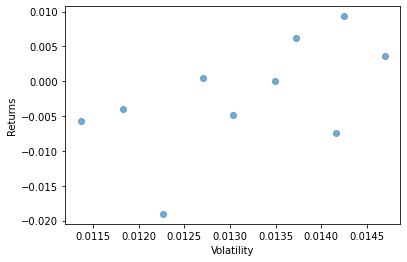

In [12]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.6)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

### Get best Sharpe ratios

In [13]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.00932403378820626


### Calculate EWMAs

In [14]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

LNG    -0.004304
SPY    -0.001003
SMLV   -0.001670
Name: 2018-04-02 00:00:00, dtype: float64


### Make features and targets

In [15]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[0.13171697 0.54797802 0.32030501]
 [0.73416099 0.22481041 0.04102859]
 [0.75045085 0.15007951 0.09946963]
 [0.02624119 0.77239193 0.20136688]
 [0.51010962 0.14158855 0.34830184]]


### Plot efficient frontier with best Sharpe ratio

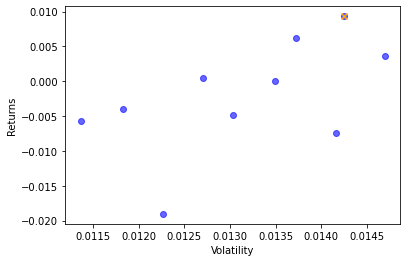

In [16]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.6, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

### Make predictions with a random forest

In [17]:
from sklearn.ensemble import RandomForestRegressor
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8271086505592926
-0.6745333319028286


### Get predictions and first evaluation

/Users/huiren/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


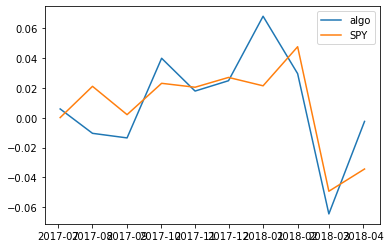

In [25]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.legend()
plt.show()

### Evaluate returns

In [26]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 0.09334039695631419
SPY returns: 0.07811831329855999


### Plot returns

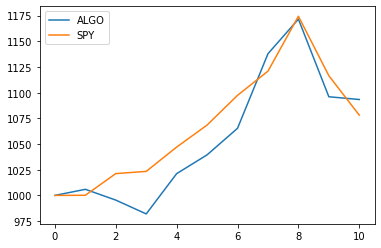

In [27]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label = 'ALGO')
plt.plot(spy_cash, label='SPY')
plt.legend() # show the legend
plt.show()